In [1]:
import pandas as pd
import geopandas as gpd
import folium
import ee

In [2]:
def initialize_gee(project_id: str, opt_url: str = 'https://earthengine-highvolume.googleapis.com') -> None:
    """Initialize Google Earth Engine with authentication"""
    ee.Authenticate()
    ee.Initialize(project=project_id, opt_url=opt_url)

In [3]:
## Here you have to use your own credentials
initialize_gee('ee-nunezrimedio-tesina')


Successfully saved authorization token.


## Data Loading

In [4]:
gdf = gpd.read_file(r"/Users/santi/DataspellProjects/Lithium-Jakob/Data/selected_basins.geojson")
gdf

,CUENCA,SISTEMA__S,REG_HIDR,geometry
0,Salar de Cauchari,Puna,Endorreica Andino-Serrana,"POLYGON Z ((-66.84383 -23.47961 0.00000, -66.8..."
1,Laguna de Guayatayoc,Puna,Endorreica Andino-Serrana,"POLYGON Z ((-65.74990 -22.24986 0.00000, -65.7..."
2,Salar de Olaroz,Puna,Endorreica Andino-Serrana,"POLYGON Z ((-66.80536 -22.78439 0.00000, -66.8..."
3,Salinas Grandes de Jujuy y Salta,Puna,Endorreica Andino-Serrana,"POLYGON Z ((-66.08321 -23.47889 0.00000, -66.0..."


## Visualizing the basins

In [5]:
## I define the bounds of the basins of interest and the mean in the x and y axis (i.e. latitude and longitude) to define the center of the map
bounds = gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Create the basemap
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)

# Add ESRI satellite basemap as a layer
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# Turn the geopandas geodataframe into a geojson object and add it as a layer to the map
folium.GeoJson(
    data=gdf.__geo_interface__,
    name='MultiPolygons',
    style_function=lambda x: {
        'fillColor': '#ff7800',
        'color': '#000',
        'weight': 2,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=gdf.columns.drop('geometry').tolist(),
        aliases=gdf.columns.drop('geometry').tolist(),
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)


# Fit the bounds as the limit of the mp
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

m

## I select the basins of interest and create ee objects
Rectangles

In [6]:
olaroz_aoi = gdf.loc[2].geometry.bounds
minx, miny, maxx, maxy = olaroz_aoi

olaroz_ee_geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

cauchari_aoi = gdf.loc[0].geometry.bounds
minx, miny, maxx, maxy = olaroz_aoi

cauchari_ee_geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

In [7]:
polygon_geom = gdf.loc[2].geometry

# Extract the coordinates of the polygon
if polygon_geom.geom_type == 'Polygon':
    # Get the exterior coordinates as (x,y) pairs
    coords = list(polygon_geom.exterior.coords)
    # Earth Engine expects a list of [x,y] coordinates
    ee_coords = [[coord[0], coord[1]] for coord in coords]
elif polygon_geom.geom_type == 'MultiPolygon':
    # Get the exterior coordinates of the first polygon
    coords = list(polygon_geom.geoms[0].exterior.coords)
    # Earth Engine expects a list of [x,y] coordinates
    ee_coords = [[coord[0], coord[1]] for coord in coords]
else:
    raise ValueError(f"Unsupported geometry type: {polygon_geom.geom_type}")

# Create an Earth Engine polygon
olaroz_ee_polygon_geometry = ee.Geometry.Polygon(ee_coords)

### Polygon earth engine objects for each basin

### Polygon for cauchari

In [8]:
polygon_geom = gdf.loc[0].geometry

# Extract the coordinates of the polygon
if polygon_geom.geom_type == 'Polygon':
    # Get the exterior coordinates as (x,y) pairs
    coords = list(polygon_geom.exterior.coords)
    # Earth Engine expects a list of [x,y] coordinates
    ee_coords = [[coord[0], coord[1]] for coord in coords]
elif polygon_geom.geom_type == 'MultiPolygon':
    # Get the exterior coordinates of the first polygon
    coords = list(polygon_geom.geoms[0].exterior.coords)
    # Earth Engine expects a list of [x,y] coordinates
    ee_coords = [[coord[0], coord[1]] for coord in coords]
else:
    raise ValueError(f"Unsupported geometry type: {polygon_geom.geom_type}")

# Create an Earth Engine polygon
cauchari_ee_polygon_geometry = ee.Geometry.Polygon(ee_coords)

## Earth Engine process and visualization

In [9]:
## Getting our first earth engine sentinel 2 image

## This is to show Jakob how to get EE images
start_date = '2023-01-01'
end_date = '2024-01-01'

s2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(olaroz_ee_geometry) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

s2_image = s2_collection.median()

s2_image
s2_image.getMapId()["tile_fetcher"].url_format

/Users/santi/miniforge3/envs/Lithium-Jakob/lib/python3.8/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


'https://earthengine-highvolume.googleapis.com/v1/projects/ee-nunezrimedio-tesina/maps/4ef0c9d6ed8dca725fee56bddf521a48-a0c112d964aaa4518c334dc3e8b0897f/tiles/{z}/{x}/{y}'

In [10]:
## Adding that image as a layer to a folium interactive map


bounds = gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Crear un mapa con una capa base satelital
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)

## Visualization parameters, the bands are RGB, this viz params you get from stackoverflow or documentation

viz = {"bands": ['B3', 'B2', 'B1'],
       "min": 0,
       "max": 2500,
       "gamma": [0.95, 1.1, 1]}


map_id_dict = s2_image.getMapId(vis_params=viz)

# This piece of code is the one thats adding the satellite image as a layer to the map
folium.raster_layers.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='satellite image',
    overlay=True,
    control=True
).add_to(m)

# adding the shape of the basins
folium.GeoJson(
    data=gdf.__geo_interface__,
    name='MultiPolygons',
    style_function=lambda x: {
        'fillColor': '#ff7800',
        'color': '#000',
        'weight': 2,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=gdf.columns.drop('geometry').tolist(),
        aliases=gdf.columns.drop('geometry').tolist(),
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)


# Ajustar el zoom para que se vean todos los polígonos
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

m

import folium
import ee
import json

# Suponiendo que ya tienes definido olaroz_aoi
minx, miny, maxx, maxy = olaroz_aoi
olaroz_ee_geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# Definir años para el análisis (5 últimos años)
years = [2021, 2022, 2023,2024,2025]

# Crear un mapa centrado en tu área de interés
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)


# Definir parámetros de visualización para todas las imágenes
viz_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # RGB
    'min': 7000,
    'max': 30000,
    'gamma': 1.4
}

# Para cada año, obtener la mediana de las imágenes de verano
for year in years:
    # Definir el periodo de verano para el hemisferio sur (dic-feb)
    start_date = f'{year-1}-01-01'
    end_date = f'{year}-12-31'

    # Obtener colección de imágenes para ese verano
    s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(olaroz_ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Calcular la mediana y recortar al área de interés
    s2_median = s2_collection.mean().clip(olaroz_ee_geometry)

    # Obtener el mapa ID y añadir como capa al mapa
    map_id_dict = s2_median.getMapId(viz_params)

    # Añadir como capa al mapa
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'Verano {year-1}-{year}',
        overlay=True,
        control=True
    ).add_to(my_map)

# Añadir el contorno del área de interés como GeoJSON estándar
# En lugar de usar olaroz_ee_geometry, creamos un GeoJSON directamente
geojson_data = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [minx, miny],
            [minx, maxy],
            [maxx, maxy],
            [maxx, miny],
            [minx, miny]  # Cerrar el polígono
        ]]
    },
    "properties": {}
}

folium.GeoJson(
    data=geojson_data,
    name='Área de interés',
    style_function=lambda x: {'color': 'red', 'fillOpacity': 0, 'weight': 2}
).add_to(my_map)

# Añadir control de capas
folium.LayerControl().add_to(my_map)

# Ajustar el zoom
my_map.fit_bounds([[miny, minx], [maxy, maxx]])

my_map

import ee
import json

# Suponiendo que ya tienes definido olaroz_aoi
minx, miny, maxx, maxy = olaroz_aoi
olaroz_ee_geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# Definir años para el análisis
years = [2021, 2022, 2023, 2024, 2025]

# Crear un mapa centrado en tu área de interés
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Definir paleta de colores para NDVI
ndvi_palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301'
]

# Parámetros de visualización para NDVI
ndvi_viz_params = {
    'min': -0.2,
    'max': 0.8,
    'palette': ndvi_palette
}

# Para cada año, calcular NDVI
for year in years:
    # Definir el periodo anual
    start_date = f'{year-1}-01-01'
    end_date = f'{year}-12-31'

    # Obtener colección de imágenes para ese año
    landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(olaroz_ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Seleccionar bandas NIR y Rojo para cada imagen y calcular NDVI directamente
    ndvi_collection = landsat_collection.map(
        lambda image: image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    )

    # Calcular la media de NDVI y recortar al área de interés
    ndvi_mean = ndvi_collection.mean().clip(olaroz_ee_geometry)

    # Obtener el mapa ID y añadir como capa al mapa
    map_id_dict = ndvi_mean.getMapId(ndvi_viz_params)

    # Añadir como capa al mapa
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'NDVI {year}',
        overlay=True,
        control=True
    ).add_to(my_map)

# Añadir el contorno del área de interés como GeoJSON estándar
geojson_data = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [minx, miny],
            [minx, maxy],
            [maxx, maxy],
            [maxx, miny],
            [minx, miny]  # Cerrar el polígono
        ]]
    },
    "properties": {}
}

folium.GeoJson(
    data=geojson_data,
    name='Área de interés',
    style_function=lambda x: {'color': 'red', 'fillOpacity': 0, 'weight': 2}
).add_to(my_map)

# Añadir control de capas
folium.LayerControl().add_to(my_map)

# Ajustar el zoom
my_map.fit_bounds([[miny, minx], [maxy, maxx]])

my_map

In [11]:
import ee
import folium

# Obtener los límites para centrar el mapa
bounds = polygon_geom.bounds
minx, miny, maxx, maxy = bounds

# Definir años para el análisis
years = [2009, 2010, 2011, 2012, 2023,2024]

# Crear un mapa centrado en el área de interés
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2

my_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# vegetation index viz params
ndvi_palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301'
]

ndvi_viz_params = {
    'min': -0.2,
    'max': 0.8,
    'palette': ndvi_palette
}

# For loop that calculates the vegetation index for each whole year in our year list
for year in years:
    # Definir el periodo anual
    start_date = f'{year-1}-01-01'
    end_date = f'{year}-12-31'

    # Now were getting landsat 7 images
    landsat_collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterBounds(olaroz_ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Debugging step
    image_count = landsat_collection.size().getInfo()
    if image_count == 0:
        print(f"No hay imágenes disponibles para {year}")
        continue
        

    # vegetation index calculation
    # For Landsat 7: B4=NIR, B3=Red
    ndvi_collection = landsat_collection.map(
        lambda image: image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    )

    # NDVI mean between the whole collection and clipping to the exact hexagon
    ndvi_mean = ndvi_collection.mean().clip(olaroz_ee_polygon_geometry)

    # Adding this to the map as a layer
    map_id_dict = ndvi_mean.getMapId(ndvi_viz_params)

    # Añadir como capa al mapa
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'NDVI {year}',
        overlay=True,
        control=True
    ).add_to(my_map)

# Añadir control de capas
folium.LayerControl().add_to(my_map)

# Mostrar el mapa
my_map

In [12]:
import ee
import folium


# years of interest list
years = [2009, 2010, 2011, 2012, 2023, 2024]

# Centering the map
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Viz params for vegetation index
ndvi_palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301'
]

# Parámetros de visualización para NDVI
ndvi_viz_params = {
    'min': -0.2,
    'max': 0.8,
    'palette': ndvi_palette
}

# Vegetation index for each year for OLAROZ
for year in years:
    # Definir el periodo anual
    start_date = f'{year-1}-01-01'
    end_date = f'{year}-12-31'

    # Obtener colección de Landsat 7 para ese año
    landsat_collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterBounds(olaroz_ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Comprobar si tenemos imágenes para este periodo
    image_count = landsat_collection.size().getInfo()
    if image_count == 0:
        print(f"No hay imágenes disponibles para Olaroz en {year}")
        continue

    # Seleccionar bandas NIR y Rojo para cada imagen y calcular NDVI directamente
    # Para Landsat 7: B4=NIR, B3=Rojo
    ndvi_collection = landsat_collection.map(
        lambda image: image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    )

    # Calcular la media de NDVI y recortar al área de interés
    ndvi_mean = ndvi_collection.mean().clip(olaroz_ee_polygon_geometry)

    # Obtener el ID del mapa y añadir como capa al mapa
    map_id_dict = ndvi_mean.getMapId(ndvi_viz_params)

    # Añadir como capa al mapa
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'Olaroz NDVI {year}',
        overlay=True,
        control=True
    ).add_to(my_map)

# Vegetation index for each year for cauchari
for year in years:
    # Definir el periodo anual
    start_date = f'{year-1}-01-01'
    end_date = f'{year}-12-31'

    # Obtener colección de Landsat 7 para ese año
    landsat_collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterBounds(cauchari_ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Comprobar si tenemos imágenes para este periodo
    image_count = landsat_collection.size().getInfo()
    if image_count == 0:
        print(f"No hay imágenes disponibles para Cauchari en {year}")
        continue

    # Seleccionar bandas NIR y Rojo para cada imagen y calcular NDVI directamente
    # Para Landsat 7: B4=NIR, B3=Rojo
    ndvi_collection = landsat_collection.map(
        lambda image: image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    )

    # Calcular la media de NDVI y recortar al área de interés
    ndvi_mean = ndvi_collection.mean().clip(cauchari_ee_polygon_geometry)

    # Obtener el ID del mapa y añadir como capa al mapa
    map_id_dict = ndvi_mean.getMapId(ndvi_viz_params)

    # Añadir como capa al mapa
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'Cauchari NDVI {year}',
        overlay=True,
        control=True
    ).add_to(my_map)

# Añadir los contornos de ambas áreas de interés
# Contorno de Olaroz
folium.GeoJson(
    data=polygon_olaroz.__geo_interface__,
    name='Área Olaroz',
    style_function=lambda x: {'color': 'red', 'fillOpacity': 0, 'weight': 2}
).add_to(my_map)

# Contorno de Cauchari
folium.GeoJson(
    data=polygon_cauchari.__geo_interface__,
    name='Área Cauchari',
    style_function=lambda x: {'color': 'blue', 'fillOpacity': 0, 'weight': 2}
).add_to(my_map)

# Añadir control de capas
folium.LayerControl().add_to(my_map)
# Ajustar zoom para ver ambas áreas
my_map.fit_bounds([[miny, minx], [maxy, maxx]])


# Mostrar el mapa
my_map

NameError: name 'polygon_olaroz' is not defined

In [80]:
my_map.save("mapa_litio.html")

## Histograms

## Histograma

## Histograma comparativo

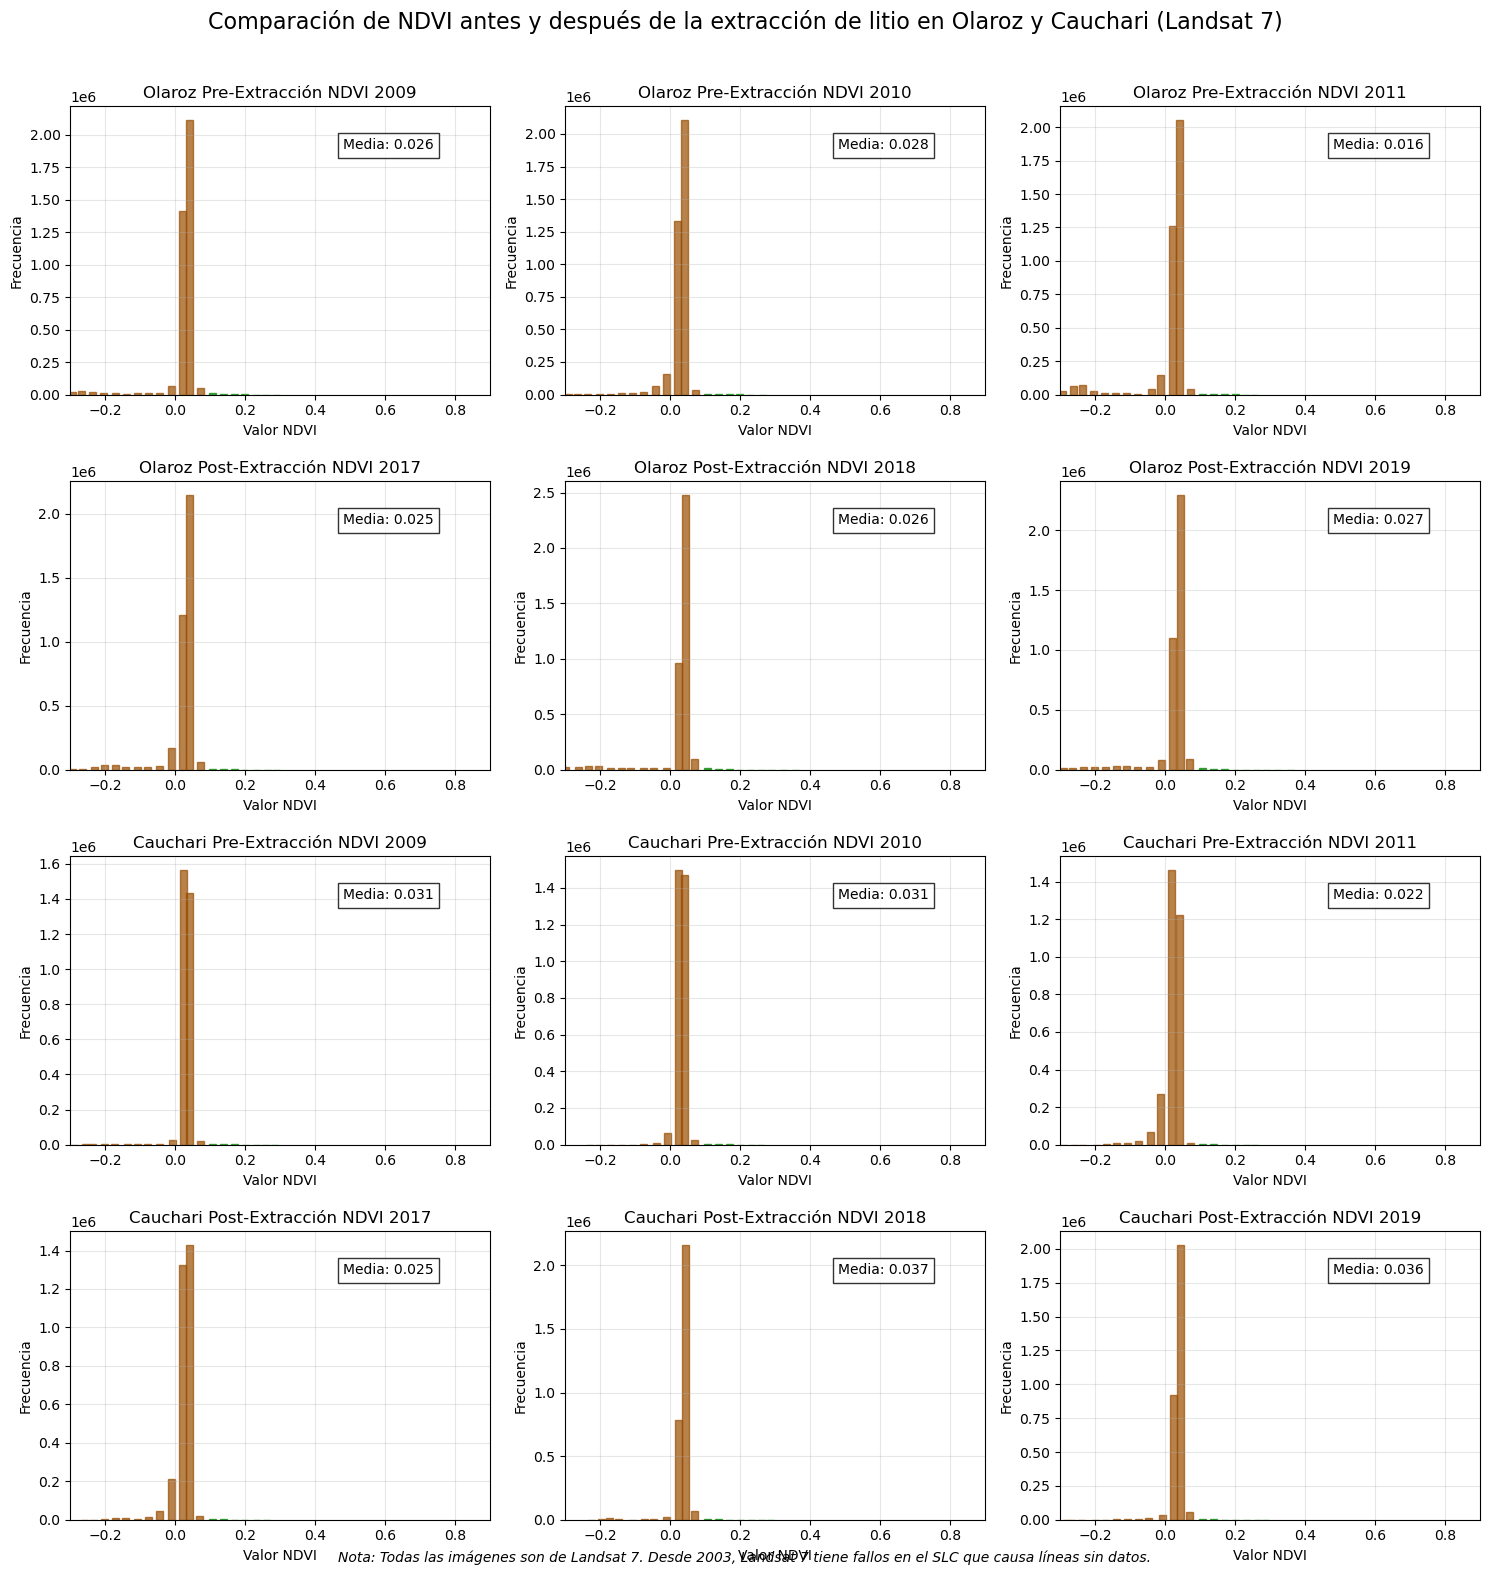

In [42]:
import ee
import matplotlib.pyplot as plt
import numpy as np

# Inicializar Earth Engine
ee.Initialize()

# Obtener las geometrías para Olaroz y Cauchari
polygon_olaroz = gdf.loc[2].geometry
polygon_cauchari = gdf.loc[0].geometry

# Convertir las geometrías a formato Earth Engine
# Para Olaroz
if polygon_olaroz.geom_type == 'Polygon':
    coords_olaroz = list(polygon_olaroz.exterior.coords)
    ee_coords_olaroz = [[coord[0], coord[1]] for coord in coords_olaroz]
elif polygon_olaroz.geom_type == 'MultiPolygon':
    coords_olaroz = list(polygon_olaroz.geoms[0].exterior.coords)
    ee_coords_olaroz = [[coord[0], coord[1]] for coord in coords_olaroz]
else:
    raise ValueError(f"Tipo de geometría no soportado para Olaroz: {polygon_olaroz.geom_type}")

# Para Cauchari
if polygon_cauchari.geom_type == 'Polygon':
    coords_cauchari = list(polygon_cauchari.exterior.coords)
    ee_coords_cauchari = [[coord[0], coord[1]] for coord in coords_cauchari]
elif polygon_cauchari.geom_type == 'MultiPolygon':
    coords_cauchari = list(polygon_cauchari.geoms[0].exterior.coords)
    ee_coords_cauchari = [[coord[0], coord[1]] for coord in coords_cauchari]
else:
    raise ValueError(f"Tipo de geometría no soportado para Cauchari: {polygon_cauchari.geom_type}")

# Crear geometrías Earth Engine
olaroz_ee_geometry = ee.Geometry.Polygon(ee_coords_olaroz)
cauchari_ee_geometry = ee.Geometry.Polygon(ee_coords_cauchari)

# Definir años antes y después de la instalación de extracción de litio
# Asumiendo que la operación comenzó en 2014-2015
before_years = [2009, 2010, 2011]  # 3 años antes
after_years = [2017, 2018, 2019]   # Años posteriores disponibles en Landsat 7

# Crear una figura para los histogramas
# 4 filas (2 para Olaroz, 2 para Cauchari) y 3 columnas (3 años)
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

# Función para procesar NDVI y dibujar histograma
def process_and_plot_ndvi(geometry, year, ax, title_prefix):
    # Definir el periodo anual
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Obtener colección de Landsat 7
    landsat_collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    # Calcular NDVI (SR_B4=NIR, SR_B3=RED)
    ndvi_collection = landsat_collection.map(
        lambda image: image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    )

    # Calcular la media de NDVI y recortar al área de interés
    ndvi_mean = ndvi_collection.mean().clip(geometry)

    # Reducers are a family of functions that allow some sort of aggregation of an image (or collection of images) in this case were doing a histogram
    histogram = ndvi_mean.reduceRegion(
        reducer=ee.Reducer.histogram(30),
        geometry=geometry,
        scale=30,
        maxPixels=1e9
    )

    # This actually runs the process and gets the data locally
    hist_data = histogram.get('NDVI').getInfo()
    if hist_data is None:
        ax.text(0.5, 0.5, f'No hay datos disponibles para {year}',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title_prefix} {year}', fontsize=12)
        return

    hist_counts = np.array(hist_data['histogram'])
    hist_buckets = np.array(hist_data['bucketMeans'])

    # Visualization of the data
    bars = ax.bar(hist_buckets, hist_counts, width=0.02, alpha=0.7)

    # Colorear las barras según el valor NDVI
    for j, bar in enumerate(bars):
        normalized_value = (hist_buckets[j] + 0.2) / 1.0
        normalized_value = max(0, min(1, normalized_value))
        if normalized_value < 0.3:
            # Marrón para valores bajos
            color = (0.6, 0.3, 0, normalized_value + 0.3)
        else:
            # Verde para valores altos
            color = (0, 0.3 + normalized_value * 0.7, 0, 0.7)
        bar.set_color(color)

    ax.set_title(f'{title_prefix} {year}', fontsize=12)
    ax.set_xlabel('Valor NDVI')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(-0.3, 0.9)
    ax.grid(True, alpha=0.3)

    # Añadir estadísticas básicas
    if len(hist_buckets) > 0:
        mean_ndvi = np.average(hist_buckets, weights=hist_counts)
        stats_text = f'Media: {mean_ndvi:.3f}'
        ax.text(0.65, 0.85, stats_text, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

# Para Olaroz - Años antes de la instalación
for i, year in enumerate(before_years):
    process_and_plot_ndvi(olaroz_ee_geometry, year, axes[0, i], 'Olaroz Pre-Extracción NDVI')

# Para Olaroz - Años después de la instalación
for i, year in enumerate(after_years):
    process_and_plot_ndvi(olaroz_ee_geometry, year, axes[1, i], 'Olaroz Post-Extracción NDVI')

# Para Cauchari - Años antes de la instalación
for i, year in enumerate(before_years):
    process_and_plot_ndvi(cauchari_ee_geometry, year, axes[2, i], 'Cauchari Pre-Extracción NDVI')

# Para Cauchari - Años después de la instalación
for i, year in enumerate(after_years):
    process_and_plot_ndvi(cauchari_ee_geometry, year, axes[3, i], 'Cauchari Post-Extracción NDVI')

# Ajustar el diseño
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3)

# Añadir un título general
fig.suptitle('Comparación de NDVI antes y después de la extracción de litio en Olaroz y Cauchari (Landsat 7)',
             fontsize=16)

# Añadir una nota sobre el SLC-off
fig.text(0.5, 0.01,
         'Nota: Todas las imágenes son de Landsat 7. Desde 2003, Landsat 7 tiene fallos en el SLC que causa líneas sin datos.',
         ha='center', fontsize=10, style='italic')

# Mostrar la figura
plt.show()

In [46]:
histogram

NameError: name 'histogram' is not defined